In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pandas_datareader import data as pdr
import yfinance as yf

2024-04-25 21:12:45.509337: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 21:12:45.571772: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 21:12:45.848874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 21:12:47.426647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Override pandas_datareader's get_data_yahoo() method
yf.pdr_override()
df = pdr.get_data_yahoo("AAPL", start="2010-01-01", end="2022-12-31")

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Load the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [6]:
# Create a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
from tensorflow.keras.layers import Input

# Create the LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [9]:
# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=1, batch_size=1)

3212/3212 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - loss: 0.0034


In [13]:
# Test the model accuracy on existing data
training_data_len = int(np.ceil(len(df) * .8))
test_data = scaled_data[training_data_len - 60: , :]
X_test = []
y_test = df['Close'].iloc[training_data_len:]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [14]:
# Check predicted values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


/tmp/ipykernel_77642/3141496365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


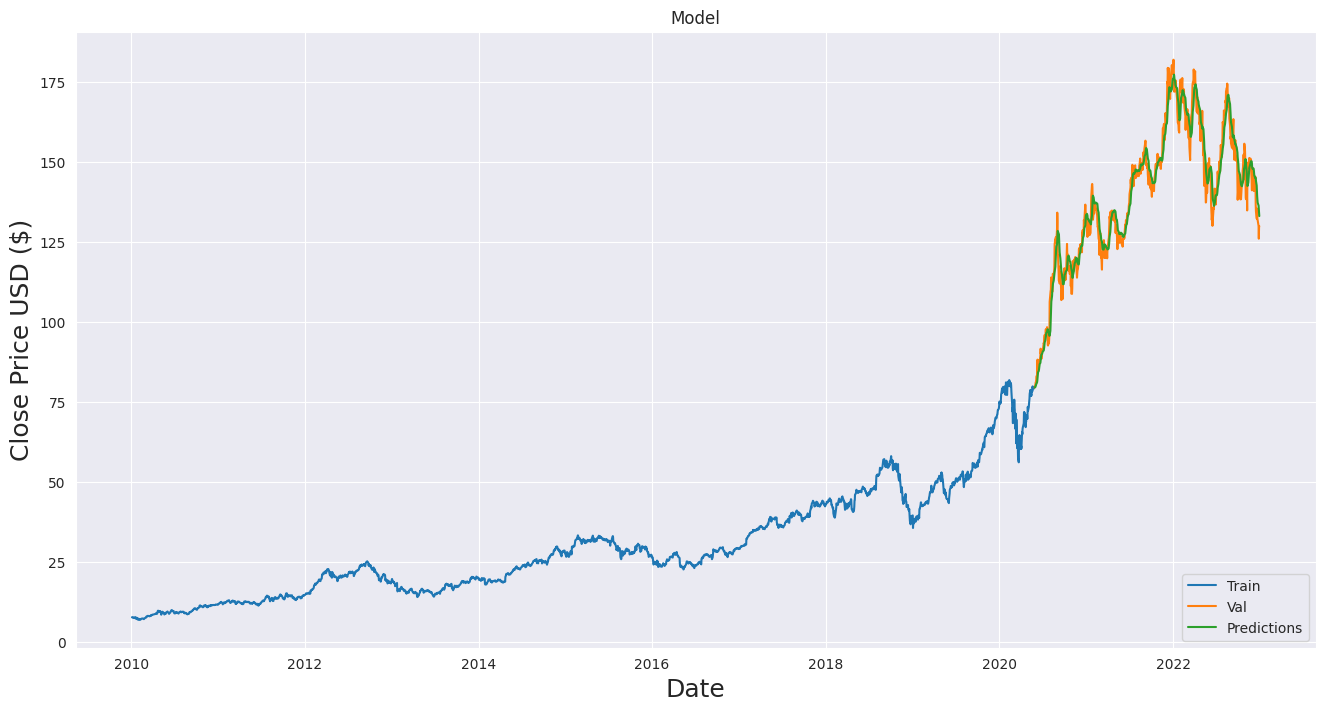

In [15]:
# Plot the data
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()